# Graph interfaces, bespoke graphs for every occasion
Mathieu Besançon, James Faibanks 

## Outline

1. Why LightGraphs?
2. LightGraphs scope
3. Live code!
4. Conclusion

## Why LightGraphs?

![](img/lglogo.png)

Graphs are fun... and useful.  
Need for a **simple**, **extensible** graph library in Julia.  
Watch Seth and James JuliaCon17 talk for motivation

## Graph applications

<img src="img/art-board-game-challenge-163064.jpg" width="230" height="180" /> Social interactions  
<img src="img/business-cargo-cargo-container-163726.jpg" width="230" height="200" /> Logistics

## Less boring?
![](img/kaggle1.png)

------------------------------

![](img/kaggle2.png)

## LightGraphs scope

LightGraphs' job is to...
- Define the core interface: what does a type need to be a graph?
- Implement essential algorithms on types implementing the interface

### Core interface

Abstract graph type `AbstractGraph`

Some methods required on graphs `f(graph)`:
* LightGraphs.edges
* LightGraphs.edgetype
* LightGraphs.is_directed
* LightGraphs.ne
* LightGraphs.nv
* LightGraphs.vertices

Methods required on nodes `f(graph,node)`:
* LightGraphs.outneighbors
* LightGraphs.inneighbors
* LightGraphs.has_vertex

Methods required for edges `f(graph, edge)`:
* LightGraphs.has_edge

Defining one own edge type:
* Base.reverse
* LightGraphs.dst
* LightGraphs.src

## Essential algorithms

In [2]:
using LightGraphs

g = CompleteBipartiteGraph(5,6)

LoadError: MethodError: no method matching pipe_writer(::IJulia.IJuliaStdio{Base.PipeEndpoint})
The applicable method may be too new: running in world age 27557, while current world is 27562.
Closest candidates are:
  pipe_writer(::IJulia.IJuliaStdio) at /Users/jamesfairbanks/.julia/packages/IJulia/RBfP/src/stdio.jl:15 (method too new to be called from this world context.)
  pipe_writer(!Matched::Base.ProcessChain) at process.jl:344
  pipe_writer(!Matched::Base.Process) at process.jl:332
  ...

In [3]:
# neighbors of the 3rd vertex
neighbors(g, 3)

LoadError: UndefVarError: neighbors not defined

In [4]:
# Dijkstra's shortest path from vertex 3 to any other
dijkstra_shortest_paths(g,3)

LoadError: UndefVarError: dijkstra_shortest_paths not defined

In [5]:
# Kruskal min-cost spanning tree
kruskal_mst(g)

LoadError: UndefVarError: kruskal_mst not defined

In [6]:
pagerank(g)

LoadError: UndefVarError: pagerank not defined

## Standing on other packages' shoulders

In [6]:
using GraphPlot

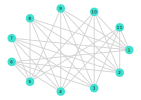

In [7]:
gplot(g, layout=GraphPlot.circular_layout , nodelabel=1:11)

### Flow algorithms like a charm

In [8]:
import LightGraphsFlows
const LGF = LightGraphsFlows;

flow_graph = DiGraph(4)
capacities = zeros(4,4)

add_edge!(flow_graph, 1, 2)
capacities[1,2] = 5.
add_edge!(flow_graph, 2, 4)
capacities[2,4] = 3.
add_edge!(flow_graph, 1, 3)
capacities[1,3] = 2.
add_edge!(flow_graph, 3, 4)
capacities[3,4] = 3.;

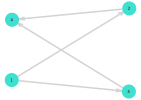

In [9]:
gplot(flow_graph, nodelabel = 1:4)

In [10]:
flow_value, flow_mat = LGF.maximum_flow(flow_graph, 1, 4, capacities)
flow_mat

4×4 Array{Float64,2}:
  0.0   3.0   2.0  0.0
 -3.0   0.0   0.0  3.0
 -2.0   0.0   0.0  2.0
  0.0  -3.0  -2.0  0.0

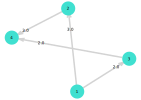

In [11]:
# flow in lexicographic order
flow_list = [flow_mat[1,2],flow_mat[1,3],flow_mat[2,4],flow_mat[3,4]]
gplot(flow_graph, nodelabel = 1:4,edgelabel = flow_list)

## A graph type for every occasion

![](img/fancycrave-254180-unsplash.jpg)

## What's the simplest way to build a graph?

* Adjacency matrix $M_{ij}$
$$M_{ij} = \begin{cases} 1, & \mbox{if edge (i $\rightarrow$ j) exists} \\ 0 & \mbox{otherwise}\end{cases}$$

* One matrix contains all the information we need
* Undirected graph $\Rightarrow$ symmetric matrix
* Accessing, modifying edges is quick

In [12]:
import Base: reverse
import LightGraphs: is_directed, ne, nv, edgetype, edges, vertices,
                    outneighbors, inneighbors, has_vertex, has_edge

mutable struct MatrixDiGraph{MT<:AbstractMatrix{Bool}} <: LightGraphs.AbstractGraph{Int}
    m::MT
end

In [13]:
# methods on the graph
is_directed(::MatrixDiGraph) = true
edgetype(::MatrixDiGraph) = LightGraphs.SimpleGraphs.SimpleEdge{Int}
ne(g::MatrixDiGraph) = sum(g.m)
nv(g::MatrixDiGraph) = size(g.m)[1]

vertices(g::MatrixDiGraph) = 1:nv(g)

function edges(g::MatrixDiGraph)
    n = nv(g)
    return (LightGraphs.SimpleGraphs.SimpleEdge(i,j) for i in 1:n for j in 1:n if g.m[i,j])
end

edges (generic function with 3 methods)

In [14]:
# methods on graph & node
outneighbors(g::MatrixDiGraph,node) = [v for v in 1:nv(g) if g.m[node,v]]
inneighbors(g::MatrixDiGraph,node) =  [v for v in 1:nv(g) if g.m[v,node]]
has_vertex(g::MatrixDiGraph,v::Integer) = v <= nv(g) && v > 0

has_vertex (generic function with 3 methods)

In [15]:
# method on edge
has_edge(g::MatrixDiGraph, e::LightGraphs.SimpleGraphs.SimpleEdge{Int}) = g.m[src(e),dst(e)]
has_edge(g::MatrixDiGraph,i,j) = g.m[i,j]

has_edge (generic function with 7 methods)

In [16]:
# Optional methods if you want mutable graphs
import LightGraphs: rem_edge!, rem_vertex!, add_edge!, add_vertex!

# return whether insertion succeeds
function add_edge!(g::MatrixDiGraph, e)
    has_edge(g,e) && return false
    n = nv(g)
    (src(e) > n || dst(e) > n) && return false
    g.m[src(e),dst(e)] = true
end

function rem_edge!(g::MatrixDiGraph,e)
    has_edge(g,e) || return false
    n = nv(g)
    (src(e) > n || dst(e) > n) && return false
    g.m[src(e),dst(e)] = false
    return true
end

function add_vertex!(g::MatrixDiGraph)
    n = nv(g)
    m = zeros(Bool,n+1,n+1)
    m[1:n,1:n] .= g.m
    return true
end

add_vertex! (generic function with 4 methods)

## Crash test for MatrixDiGraph
![](img/firework-new-year-s-eve-rocket-3893.jpg)

### PageRank algorithm

* Easy to grasp
* Concrete applications
* Nice theory behind

Data from the Stanford Network Analysis Project (SNAP)

In [17]:
import SNAPDatasets
data = SNAPDatasets.loadsnap(:ego_twitter_d)

{81306, 1768149} directed simple Int64 graph

In [18]:
adjacency_matrix(data)

81306×81306 SparseMatrixCSC{Int64,Int64} with 1768149 stored entries:
  [3    ,     1]  =  1
  [4    ,     1]  =  1
  [5    ,     1]  =  1
  [6    ,     1]  =  1
  [8    ,     1]  =  1
  [13   ,     1]  =  1
  [17   ,     1]  =  1
  [19   ,     1]  =  1
  [20   ,     1]  =  1
  [21   ,     1]  =  1
  ⋮
  [16170, 81296]  =  1
  [16170, 81297]  =  1
  [16170, 81298]  =  1
  [59529, 81299]  =  1
  [59529, 81300]  =  1
  [59529, 81301]  =  1
  [59529, 81302]  =  1
  [59529, 81303]  =  1
  [59529, 81304]  =  1
  [59529, 81305]  =  1
  [59529, 81306]  =  1

In [19]:
twitter_graph = MatrixDiGraph(adjacency_matrix(data)[1:10,1:10].==1);

In [20]:
ranks = pagerank(twitter_graph)

10-element Array{Float64,1}:
 0.125202 
 0.125316 
 0.0746437
 0.0811664
 0.118521 
 0.157039 
 0.0887409
 0.103414 
 0.022543 
 0.103414 

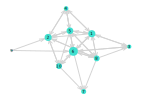

In [21]:
gplot(twitter_graph, nodesize=ranks, nodelabel=1:nv(twitter_graph))

In [22]:
bigger_twitter = MatrixDiGraph(adjacency_matrix(data)[1:500,1:500].==1);
big_ranks = pagerank(bigger_twitter)
gplot(bigger_twitter, nodesize=big_ranks, nodelabel=1:nv(bigger_twitter))

## Overloading non-primitive functions

If your type supports a faster way to do something, use it

In [23]:
import LightGraphs: adjacency_matrix
using BenchmarkTools: @btime

@btime adjacency_matrix(bigger_twitter)
println("why did that take so long?")
adjacency_matrix(g::MatrixDiGraph) = g.m
@btime A = adjacency_matrix(bigger_twitter)
println("that's better.")

  3.671 ms (5222 allocations: 682.03 KiB)
why did that take so long?
  11.787 ns (0 allocations: 0 bytes)
that's better.


In [1]:
normalized_cut(bigger_twitter)

LoadError: UndefVarError: normalized_cut not defined

## Wrap-up

* Design specialized graph types for your needs, you know best!
* Define a couple functions describing behavior
* Use the JuliaGraphs ecosystem for free, build on top 

React, complain, contribute: 
- *github.com/JuliaGraphs*
- Discourse
- Slack `#graphs` channel

## Bonus

One graph type to rule them all

In [24]:
mutable struct GraphMatrix{MT<:AbstractMatrix{Bool}} <: LightGraphs.AbstractGraph{Int64}
    m::MT
    is_directed::Bool
end

# methods on the graph
is_directed(g::GraphMatrix) = g.is_directed
reverse(g::GraphMatrix) = is_directed(g) ? GraphMatrix(m',true) : g
edgetype(::GraphMatrix) = LightGraphs.SimpleGraphs.SimpleEdge{Int64}
ne(g::GraphMatrix) = is_directed(g) ? sum(g.m) : div(sum(g.m),2)
nv(g::GraphMatrix) = size(g.m)[1]

vertices(g::GraphMatrix) = 1:nv(g)

function edges(g::GraphMatrix)
    n = nv(g)
    if g.is_directed
        return (LightGraphs.SimpleGraphs.SimpleEdge(i,j) for i in 1:n for j in 1:n if g.m[i,j])
    else
        return (LightGraphs.SimpleGraphs.SimpleEdge(i,j) for i in 1:n for j in i+1:n if g.m[i,j])
    end
end

edges (generic function with 4 methods)

## Links & sources

<sub><sup>Photo by Fancycrave on Unsplash</sup></sub>  
<sub><sup>https://www.pexels.com/photo/close-up-photography-of-yellow-green-red-and-brown-plastic-cones-on-white-lined-surface-163064/</sup></sub>  
<sub><sup>https://www.pexels.com/photo/firework-new-year-s-eve-rocket-3893/</sup></sub>  
<sub><sup>https://www.pexels.com/photo/blue-white-orange-and-brown-container-van-163726/</sup></sub>